In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

# One Factor Anova F-Test

### Dataset
The dataset includes the weight (in grams) of fruit from three different types of trees (A, B, and C). Each tree type has 10 observations.

In [2]:
data = pd.read_csv("data/trees.csv")

In [3]:
data

,A,B,C
0,100,90,80
1,110,100,90
2,120,110,100
3,130,120,110
4,140,130,120
5,150,140,130
6,160,150,140
7,170,160,150
8,180,170,160
9,190,180,170


In [4]:
data_melt = data.melt(var_name="tree",value_name="weight")

In [5]:
data_melt.head()

,tree,weight
0,A,100
1,A,110
2,A,120
3,A,130
4,A,140


### Research problem
Is there a significant difference in the mean weight of fruit among trees A, B, and C?

### Statistical Hypothesis
$$
H_0 : \mu_A = \mu_B =\mu_C \\
H_1 : H_0 \text{ is false.}
$$

In [6]:
alpha = 0.05
df_b = 3-1
df_w = len(data)-3

In [7]:
# F critical = alpha | df between | df within
F_critical = stats.f.ppf(1-alpha,df_b,df_w)
F_critical

4.73741412777588

### Decision Rule
Reject $H_0$ at the .05 level of significance if F ≥ 3.354.

### Calculations
$$
F = \frac {MS(groups)} {MS(error)}
$$

In [8]:
formula = 'weight ~ C(tree)'
model = ols(formula, data_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2) # Type 2 sum of squares method
# Calculating the MS
anova_table['mean_sq'] = anova_table['sum_sq'] / anova_table['df']
anova_table = anova_table.reindex(columns=['sum_sq','df', 'mean_sq', 'F', 'PR(>F)'])

In [9]:
anova_table

,sum_sq,df,mean_sq,F,PR(>F)
C(tree),2000.0,2.0,1000.000000,1.090909,0.350263
Residual,24750.0,27.0,916.666667,NaN,NaN


In [10]:
F = anova_table["F"][0]
F >= F_critical,F

(False, 1.0909090909090866)

In [11]:
p = anova_table["PR(>F)"][0]
p>alpha,p

(True, 0.35026289130975924)

### Decision
Retain $H_0$ at the .05 level of significance because F = 1.09, and p > alpha, not enough evidence to reject it.  

### Interpretation
There is no significant difference in the mean weight of fruit among trees A, B, and C, and we do not have enough evidence to reject it.

***

# Two Factor Anova  three F-Test

### Dataset
A botanist wants to know whether or not plant growth is influenced by sunlight exposure and watering frequency. She plants 30 seeds and lets them grow for two months under different conditions for sunlight exposure and watering frequency. After two months, she records the height of each plant, in inches.

- water: how frequently each plant was watered: daily or weekly
- sun: how much sunlight exposure each plant received: low, medium, or high
- height: the height of each plant (in inches) after two months

| sun | low| med| high|
| --- | --- | --- | ---|
| daily | $\ddots$|$\ddots$ |$\ddots$ |
| weekly | $\ddots$|$\ddots$ | $\ddots$|

In [12]:
data = pd.read_csv("data/plants.csv")

In [13]:
data.head()

,water,sun,height
0,daily,low,6
1,daily,low,6
2,daily,low,6
3,daily,low,5
4,daily,low,6


In [14]:
table = pd.read_csv("data/plants_table.csv").set_index("water")

In [15]:
table

,low,mid,high
water,,,
daily,6,5,6
daily,6,5,6
daily,6,6,7
daily,5,4,8
daily,6,5,7
weekly,3,4,5
weekly,4,4,6
weekly,4,4,6
weekly,4,4,7


### Research problem
Determine if watering frequency and sunlight exposure have a significant effect on plant growth, and to determine if there is any interaction effect between watering frequency and sunlight exposure.

### Statistical Hypothesis

$H_0$: The plant growth is not influenced by either watering frequency or sunlight exposure or their interaction.

$$
H_0: \mu_{weekly} = \mu_{daily}  \\
H_0: \mu_{high} = \mu_{med} = \mu_{low} \\
H_0: no~interaction \\
H_1: H_0~is~not~true.
$$

In [16]:
alpha = 0.05
c = table.shape[1]
r = 2
N = len(data)

In [17]:
df = {
    "c" : c-1,
    "r": r-1,
    "w": N - c*r,
    "i":  (c-1) * (r-1),
}
df

{'c': 2, 'r': 1, 'w': 24, 'i': 2}

In [18]:
F_criticals = {
    "column": stats.f.ppf(1-alpha,df["c"],df["w"]),
    "row": stats.f.ppf(1-alpha,df["r"],df["w"]),
    "interaction": stats.f.ppf(1-alpha,df["i"],df["w"]),
}
F_criticals

{'column': 3.4028261053501945,
 'row': 4.259677272690231,
 'interaction': 3.4028261053501945}

### Decision Rule
Reject $H_0$ at the .05 level of significance if $F_c$ or $F_i$ ≥ 3.40 and if $F_{r} \ge 4.25$.

### Calculations
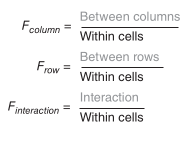

In [19]:
model = ols('height ~ C(water) + C(sun) + C(water):C(sun)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

In [20]:
# Calculating the MS
anova_table['mean_sq'] = anova_table['sum_sq'] / anova_table['df']
anova_table = anova_table.reindex(columns=['sum_sq','df', 'mean_sq', 'F', 'PR(>F)'])

In [21]:
anova_table

,sum_sq,df,mean_sq,F,PR(>F)
C(water),8.533333,1.0,8.533333,16.0000,0.000527
C(sun),24.866667,2.0,12.433333,23.3125,0.000002
C(water):C(sun),2.466667,2.0,1.233333,2.3125,0.120667
Residual,12.800000,24.0,0.533333,NaN,NaN


In [22]:
F = anova_table["F"][:-1].to_numpy()

In [23]:
P = anova_table["PR(>F)"][:-1].to_numpy()

In [24]:
for i,k in enumerate(F_criticals.keys()):
    print(f"F_{k}>={F_criticals[k]}:",F[i]>=F_criticals[k],"\np>alpha:",P[i]>alpha)
    print()

F_column>=3.4028261053501945: True 
p>alpha: False

F_row>=4.259677272690231: True 
p>alpha: False

F_interaction>=3.4028261053501945: False 
p>alpha: True



### Decision
Reject the first two null hypotheses at the .05 level of significance and retain the third null hypothesis.

### Interpretation
Both the water and sunlight have statistically significant effect on plant height and there is no significant interaction effect between sunlight exposure and watering frequency.